# YouTube Channel View Prediction: Ensemble Learning in Google Colab
This Jupyter Notebook documents the process of building and evaluating machine learning models, specifically focusing on combining XGBoost and Random Forest using an **averaging ensemble method**. It includes data preprocessing, logarithmic transformation of the target, hyperparameter tuning, and evaluation of the ensemble model on the original scale of video views.

## 1. Setup and Library Imports
This section imports all necessary Python libraries for data manipulation, machine learning, and evaluation. We also suppress warnings for cleaner output.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer
import numpy as np # Import numpy for log transformation and ensemble averaging
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")


Libraries imported successfully!


## 2. Data Loading
Here, we'll load the "Global YouTube Statistics" dataset into a Pandas DataFrame. Before running this cell, make sure you've uploaded your `Global-YouTube-Statistics.csv` file to your Colab environment or mounted your Google Drive.

If you chose to upload the file directly to Colab, it will reside in the current session's /content/ directory.

In [2]:
# --- 1. Load Data ---
print("Loading Data...")
try:
    # Option 1: If you uploaded the file directly to Colab (e.g., using files.upload())
    # The file will be in the default content directory.
    # Try different encodings if 'utf-8' fails. Common alternatives are 'latin1' or 'cp1252'.
    df = pd.read_csv('./Global-YouTube-Statistics.csv', encoding='latin1')

    # If 'latin1' doesn't work, try 'cp1252':
    # df = pd.read_csv('Global-YouTube-Statistics.csv', encoding='cp1252')

    # Option 2: If you mounted Google Drive (uncomment and adjust path if needed)
    # from google.colab import drive
    # drive.mount('/content/drive')
    # df = pd.read_csv('/content/drive/MyDrive/path/to/Global-YouTube-Statistics.csv', encoding='latin1') # <--- ADJUST THIS PATH AND ADD ENCODING

    print("Dataset loaded successfully.")
    print(f"Initial shape: {df.shape}")
    print("Columns:", df.columns.tolist())
    print("\nFirst 5 rows of the dataset:")
    print(df.head())
except FileNotFoundError:
    print("Error: 'Global-YouTube-Statistics.csv' not found. Please ensure the file is in the correct directory or uploaded.")
    print("If you just uploaded it, restart the kernel and try again, or check the file name carefully.")
except Exception as e:
    print(f"An error occurred while loading the dataset: {e}")
    print("Consider trying a different 'encoding' parameter in pd.read_csv() if the error persists (e.g., encoding='cp1252').")



Loading Data...
Dataset loaded successfully.
Initial shape: (995, 28)
Columns: ['rank', 'Youtuber', 'subscribers', 'video views', 'category', 'Title', 'uploads', 'Country', 'Abbreviation', 'channel_type', 'video_views_rank', 'country_rank', 'channel_type_rank', 'video_views_for_the_last_30_days', 'lowest_monthly_earnings', 'highest_monthly_earnings', 'lowest_yearly_earnings', 'highest_yearly_earnings', 'subscribers_for_last_30_days', 'created_year', 'created_month', 'created_date', 'Gross tertiary education enrollment (%)', 'Population', 'Unemployment rate', 'Urban_population', 'Latitude', 'Longitude']

First 5 rows of the dataset:
   rank                    Youtuber  subscribers   video views  \
0     1                    T-Series    245000000  2.280000e+11   
1     2              YouTube Movies    170000000  0.000000e+00   
2     3                     MrBeast    166000000  2.836884e+10   
3     4  Cocomelon - Nursery Rhymes    162000000  1.640000e+11   
4     5                   SET 

## 3. Data Preprocessing and Feature Engineering
This is a crucial step where we clean the data, handle missing values, and transform features into a format suitable for machine learning models.

### Handling Missing Values
We'll fill missing numerical values with the column's median and missing categorical values with the mode. This prevents errors during model training.

In [3]:
print("Handling missing values...")
# For numerical columns, fill with median
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
for col in numerical_cols:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"  Filled missing values in '{col}' with median: {median_val}")

# For categorical columns, fill with mode
categorical_cols = df.select_dtypes(include='object').columns.tolist()
for col in categorical_cols:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)
        print(f"  Filled missing values in '{col}' with mode: {mode_val}")

# Ensure no remaining NaN/infinite values before proceeding
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print(f"Shape after handling NaNs/Infs: {df.shape}")



Handling missing values...
  Filled missing values in 'video_views_rank' with median: 915.5
  Filled missing values in 'country_rank' with median: 51.0
  Filled missing values in 'channel_type_rank' with median: 65.5
  Filled missing values in 'video_views_for_the_last_30_days' with median: 64085000.0
  Filled missing values in 'subscribers_for_last_30_days' with median: 200000.0
  Filled missing values in 'created_year' with median: 2013.0
  Filled missing values in 'created_date' with median: 16.0
  Filled missing values in 'Gross tertiary education enrollment (%)' with median: 68.0
  Filled missing values in 'Population' with median: 328239523.0
  Filled missing values in 'Unemployment rate' with median: 9.365
  Filled missing values in 'Urban_population' with median: 270663028.0
  Filled missing values in 'Latitude' with median: 37.09024
  Filled missing values in 'Longitude' with median: -51.92528
  Filled missing values in 'category' with mode: Entertainment
  Filled missing valu

### Feature Creation: `created_date_numeric`
We combine `created_year` and `created_month` into a single numerical feature to represent the channel's creation timeline.

In [4]:
# Feature Engineering: Combine created_year and created_month into a single numerical feature
# Convert month abbreviations to numerical month (1-12)
df['created_month_numeric'] = df['created_month'].apply(lambda x: pd.to_datetime(x, format='%b').month)
df['created_date_numeric'] = df['created_year'] + (df['created_month_numeric'] / 12)
print("Created 'created_date_numeric' feature.")



Created 'created_date_numeric' feature.


### Categorical Feature Encoding
Categorical features like `category` and `Country` need to be converted into numerical representations. We'll use `LabelEncoder` for this.

In [5]:
print("Encoding categorical features...")
label_encoders = {}
for col in ['category', 'Country', 'channel_type']: # 'created_month' is now used in 'created_date_numeric'
    if col in df.columns:
        le = LabelEncoder()
        df[col + '_encoded'] = le.fit_transform(df[col])
        label_encoders[col] = le
        print(f"  Encoded '{col}' into '{col}_encoded'.")
    else:
        print(f"  Warning: Column '{col}' not found for encoding.")


Encoding categorical features...
  Encoded 'category' into 'category_encoded'.
  Encoded 'Country' into 'Country_encoded'.
  Encoded 'channel_type' into 'channel_type_encoded'.


### Feature and Target Selection (with Log Transformation)
We define the set of input features (X) and apply a logarithmic transformation to the `video views` target variable (y). This helps to handle the skewed distribution often found in view counts, which can significantly improve model performance and make evaluation metrics more meaningful.

In [6]:
# Select features and target variable
# MODIFIED: Using a selected subset of features (e.g., top 10 from previous analysis)
features = [
    'subscribers',
    'video_views_rank',
    'created_date_numeric',
    'channel_type_rank',
    'uploads',
    'video_views_for_the_last_30_days',
    'subscribers_for_last_30_days',
    'category_encoded',
    'lowest_yearly_earnings'
]


# Ensure all selected features exist in the DataFrame
existing_features = [f for f in features if f in df.columns]
if len(existing_features) != len(features):
    missing = set(features) - set(existing_features)
    print(f"Warning: The following features were not found in the dataset and will be excluded: {missing}")
    features = existing_features

target = 'video views' # Your chosen target

X = df[features]
# Apply logarithmic transformation (log1p to handle zero values gracefully)
y = np.log1p(df[target])
print(f"Applied log1p transformation to the target variable '{target}'.")
print("Remember to use np.expm1() on predictions to convert them back to the original scale.")

print(f"Selected {len(features)} features and target '{target}'.")
print(f"X shape: {X.shape}, y shape: {y.shape}")


Applied log1p transformation to the target variable 'video views'.
Remember to use np.expm1() on predictions to convert them back to the original scale.
Selected 9 features and target 'video views'.
X shape: (995, 9), y shape: (995,)


### Feature Scaling
Numerical features are scaled using `StandardScaler` to normalize their range. This is particularly important for SVR and can improve the performance of tree-based models as well.

In [7]:
print("Scaling numerical features...")
scaler = StandardScaler()
numerical_features_to_scale = X.select_dtypes(include=np.number).columns.tolist()
X[numerical_features_to_scale] = scaler.fit_transform(X[numerical_features_to_scale])
print("Numerical features scaled.")
print("\nFirst 5 rows of the scaled feature set (X):")
print(X.head())


Scaling numerical features...
Numerical features scaled.

First 5 rows of the scaled feature set (X):
   subscribers  video_views_rank  created_date_numeric  channel_type_rank  \
0    12.674193         -0.406670             -1.536414          -0.377155   
1     8.392710          2.571724             -1.536414           3.499058   
2     8.164364         -0.406636             -0.222450          -0.377155   
3     7.936019         -0.406670             -1.425374          -0.377155   
4     7.764759         -0.406669             -1.425374          -0.376633   

    uploads  video_views_for_the_last_30_days  subscribers_for_last_30_days  \
0  0.319178                          5.156029                      3.374616   
1 -0.269118                         -0.418012                     -0.195539   
2 -0.247439                          2.909626                     15.275134   
3 -0.240847                          4.457422                      1.391196   
4  3.144908                          4.0

## 4. Data Splitting (No Longer for Primary Evaluation)
While we traditionally split data into training and testing, for k-fold cross-validation and hyperparameter tuning, we will use the entire dataset for evaluation. The `train_test_split` is not directly needed for the primary evaluation with `cross_val_score`, as `cross_val_score` handles the internal splitting for evaluation. However, if you intend to train a final model on the full dataset after evaluating with cross-validation, or to perform hyperparameter tuning with a separate validation set, `train_test_split` could still be used. For now, we'll proceed directly to cross-validation.

In [8]:
# The following lines are commented out as cross_val_score uses the full dataset for internal splits.
# If you plan to use a dedicated test set AFTER cross-validation for a final, unbiased evaluation
# of the *best* model (e.g., after hyperparameter tuning), you would uncomment and use this split.
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
# print(f"Testing set shape: X_test={X_test.shape}, y_test={y_test.shape}")

print("Proceeding to K-Fold Cross-Validation and Hyperparameter Tuning for robust model evaluation.")



Proceeding to K-Fold Cross-Validation and Hyperparameter Tuning for robust model evaluation.


## 5. Model Training and Evaluation with K-Fold Cross-Validation
This section performs k-fold cross-validation for each of your chosen models (XGBoost, Random Forest, SVR). This provides a more reliable estimate of model performance than a single train/test split. We'll then proceed to fine-tune XGBoost and Random Forest using Grid Search and Randomized Search.

We'll use R-squared as the primary scoring metric, and also display Mean Absolute Error (MAE).

In [9]:
# --- 5.1 Initial K-Fold Cross-Validation (Baseline) ---
print("5.1 Initial K-Fold Cross-Validation (Baseline) ...")

models = {
    'XGBoost': XGBRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'SVR': SVR()
}

cv_results = {}
n_splits = 5 # Number of folds for cross-validation

# Define a scorer for Mean Absolute Error (MAE)
# Note: For log-transformed target, MAE will be on the log scale.
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

print(f"Performing {n_splits}-fold cross-validation for each model...\n")

for name, model in models.items():
    print(f"  Evaluating {name} model...")
    try:
        # Use R-squared as the primary metric for cross_val_score
        # Changed n_jobs from -1 to 1 to avoid _posixsubprocess error
        r2_scores = cross_val_score(model, X, y, cv=n_splits, scoring='r2', n_jobs=1)
        mean_r2 = r2_scores.mean()
        std_r2 = r2_scores.std()

        # To get MAE, use neg_mean_absolute_error and convert back to positive
        # MAE here will be on the log-transformed scale
        # Changed n_jobs from -1 to 1 to avoid _posixsubprocess error
        neg_mae_scores = cross_val_score(model, X, y, cv=n_splits, scoring='neg_mean_absolute_error', n_jobs=1)
        mean_mae = -neg_mae_scores.mean()
        std_mae = neg_mae_scores.std()

        cv_results[name] = {
            'Mean R2': mean_r2,
            'Std R2': std_r2,
            'Mean MAE': mean_mae,
            'Std MAE': std_mae
        }
        print(f"    {name} - Mean R-squared (R2): {mean_r2:.4f} (Std: {std_r2:.4f})")
        print(f"    {name} - Mean Absolute Error (MAE) (log-scale): {mean_mae:.4f} (Std: {std_mae:.4f})")
    except Exception as e:
        print(f"    Error evaluating {name} with cross-validation: {e}")
        cv_results[name] = {'Mean R2': 'Error', 'Std R2': 'Error', 'Mean MAE': 'Error', 'Std MAE': 'Error'}

print("\n--- Summary of Initial K-Fold Cross-Validation Performance ---")
for name, metrics in cv_results.items():
    print(f"Model: {name}")
    # Conditional formatting: check if the value is a float or int before formatting
    print(f"  Mean R2: {metrics['Mean R2']:.4f}" if isinstance(metrics['Mean R2'], (float, int)) else f"  Mean R2: {metrics['Mean R2']}",
          f"(Std: {metrics['Std R2']:.4f})" if isinstance(metrics['Std R2'], (float, int)) else f"(Std: {metrics['Std R2']})")
    print(f"  Mean MAE (log-scale): {metrics['Mean MAE']:.4f}" if isinstance(metrics['Mean MAE'], (float, int)) else f"  Mean MAE (log-scale): {metrics['Mean MAE']}",
          f"(Std: {metrics['Std MAE']:.4f})" if isinstance(metrics['Std MAE'], (float, int)) else f"(Std: {metrics['Std MAE']})")
    print("-" * 30)

print("\nInitial K-Fold Cross-Validation finished. Proceeding to Hyperparameter Tuning.")


5.1 Initial K-Fold Cross-Validation (Baseline) ...
Performing 5-fold cross-validation for each model...

  Evaluating XGBoost model...
    XGBoost - Mean R-squared (R2): 0.4052 (Std: 0.2044)
    XGBoost - Mean Absolute Error (MAE) (log-scale): 0.3696 (Std: 0.2202)
  Evaluating Random Forest model...
    Random Forest - Mean R-squared (R2): 0.0224 (Std: 0.4569)
    Random Forest - Mean Absolute Error (MAE) (log-scale): 0.4249 (Std: 0.2094)
  Evaluating SVR model...
    SVR - Mean R-squared (R2): 0.0390 (Std: 0.0709)
    SVR - Mean Absolute Error (MAE) (log-scale): 0.7111 (Std: 0.2965)

--- Summary of Initial K-Fold Cross-Validation Performance ---
Model: XGBoost
  Mean R2: 0.4052 (Std: 0.2044)
  Mean MAE (log-scale): 0.3696 (Std: 0.2202)
------------------------------
Model: Random Forest
  Mean R2: 0.0224 (Std: 0.4569)
  Mean MAE (log-scale): 0.4249 (Std: 0.2094)
------------------------------
Model: SVR
  Mean R2: 0.0390 (Std: 0.0709)
  Mean MAE (log-scale): 0.7111 (Std: 0.2965)
-----

### 5.2 Hyperparameter Tuning with GridSearchCV (for XGBoost)
We'll use `GridSearchCV` to systematically search for the best combination of hyperparameters for the XGBoost model. This can be computationally intensive if the grid is too large. We aim for the highest R-squared score.

Note: For a truly exhaustive search and potentially higher scores, you might need to broaden these ranges and increase `n_estimators` (e.g., up to 500 or 1000) and/or `max_depth` (e.g., up to 10 or 15), but this will significantly increase computation time.

In [10]:
# --- 5.2 Hyperparameter Tuning with GridSearchCV (for XGBoost) ---
print("\n5.2 Hyperparameter Tuning with GridSearchCV (for XGBoost)...")

# Define the parameter grid for XGBoost - EXPANDED RANGES
param_grid_xgb = {
    'n_estimators': [100, 300, 500], # Increased max estimators
    'max_depth': [3, 5, 7],         # Increased max depth
    'learning_rate': [0.005, 0.01, 0.05, 0.1], # Finer granularity and lower values
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

xgb_model = XGBRegressor(random_state=42)

# Set up GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    scoring='r2',  # Optimize for R-squared
    cv=n_splits,   # Use the same number of folds as before
    n_jobs=1,     # Changed from -1 to 1 to avoid _posixsubprocess error
    verbose=0      # Provide progress updates
)

print("Starting GridSearchCV for XGBoost. This may take some time...")
grid_search_xgb.fit(X, y) # Fit on the full data for cross-validation

print("\n--- GridSearchCV Results for XGBoost ---")
print(f"Best parameters found: {grid_search_xgb.best_params_}")
print(f"Best R-squared score (from cross-validation): {grid_search_xgb.best_score_:.4f}")

# You can also access the full results:
# cv_results_xgb = pd.DataFrame(grid_search_xgb.cv_results_)
# print("\nFull GridSearchCV results (first 5 rows):")
# print(cv_results_xgb.head())



5.2 Hyperparameter Tuning with GridSearchCV (for XGBoost)...
Starting GridSearchCV for XGBoost. This may take some time...

--- GridSearchCV Results for XGBoost ---
Best parameters found: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.9}
Best R-squared score (from cross-validation): 0.4375


### 5.3 Hyperparameter Tuning with RandomizedSearchCV (for Random Forest)
`RandomizedSearchCV` is generally more efficient for larger parameter spaces as it samples a fixed number of parameter settings from specified distributions. This is often preferred over `GridSearchCV` when the search space is vast.

Note: We've increased `n_iter` to sample more combinations from the expanded parameter distributions.

In [11]:
# --- 5.3 Hyperparameter Tuning with RandomizedSearchCV (for Random Forest) ---
print("\n5.3 Hyperparameter Tuning with RandomizedSearchCV (for Random Forest)...")

from scipy.stats import randint, uniform # For defining distributions

# Define the parameter distributions for Random Forest - EXPANDED RANGES
param_dist_rf = {
    'n_estimators': randint(200, 800), # Increased range for estimators
    'max_depth': randint(8, 25),     # Increased range for max depth
    'min_samples_split': randint(2, 25), # Slightly wider range
    'min_samples_leaf': randint(1, 15),  # Slightly wider range
    'max_features': ['auto', 'sqrt', 'log2', uniform(0.5, 0.4)], # Explore a continuous range for fractions
    'bootstrap': [True, False]
}

rf_model = RandomForestRegressor(random_state=42)

# Set up RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist_rf,
    n_iter=100,      # Increased number of sampled settings (from 50 to 100)
    scoring='r2',    # Optimize for R-squared
    cv=n_splits,     # Use the same number of folds
    random_state=42, # For reproducibility
    n_jobs=1,       # Changed from -1 to 1 to avoid _posixsubprocess error
    verbose=0        # Provide progress updates
)

print("Starting RandomizedSearchCV for Random Forest. This may take some time...")
random_search_rf.fit(X, y) # Fit on the full data for cross-validation

print("\n--- RandomizedSearchCV Results for Random Forest ---")
print(f"Best parameters found: {random_search_rf.best_params_}")
print(f"Best R-squared score (from cross-validation): {random_search_rf.best_score_:.4f}")

# You can also access the full results:
# cv_results_rf = pd.DataFrame(random_search_rf.cv_results_)
# print("\nFull RandomizedSearchCV results (first 5 rows):")
# print(cv_results_rf.head())



5.3 Hyperparameter Tuning with RandomizedSearchCV (for Random Forest)...
Starting RandomizedSearchCV for Random Forest. This may take some time...

--- RandomizedSearchCV Results for Random Forest ---
Best parameters found: {'bootstrap': True, 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 576}
Best R-squared score (from cross-validation): 0.3186


## 6. Ensemble Model Training and Evaluation on Original Scale
This section will train the individual best-tuned XGBoost and Random Forest models, combine their predictions using simple averaging, and then evaluate the ensemble model's performance on the original scale of video views using `np.expm1()`.


6.1 Final Model Training (Best Tuned Individual Models)...
Best XGBoost model parameters: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 7, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.9, 'tree_method': None, 'validate_parameters': None, 'verbosity

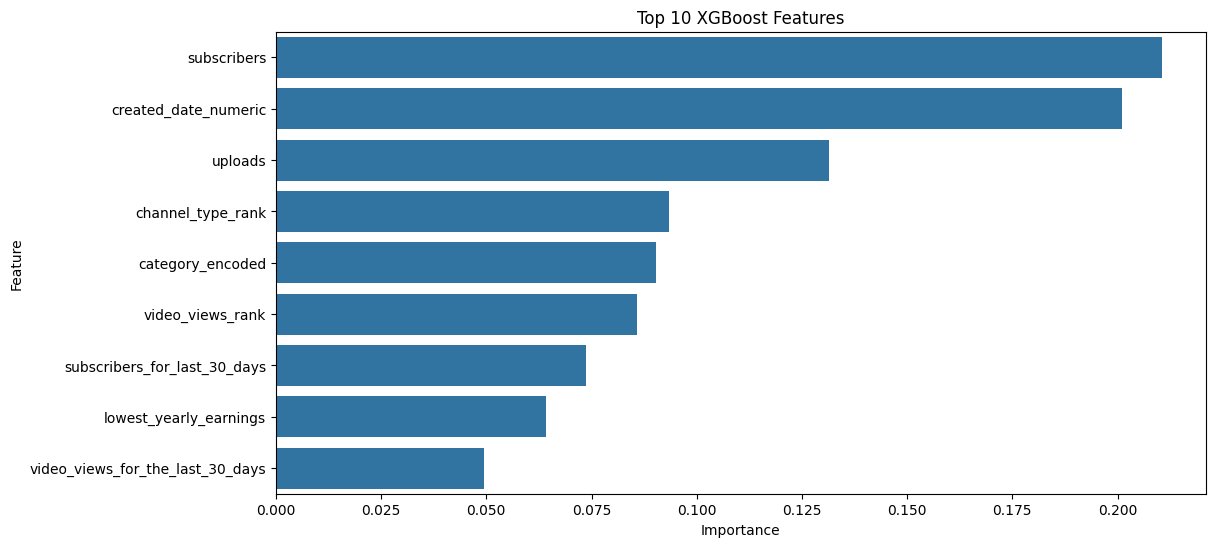

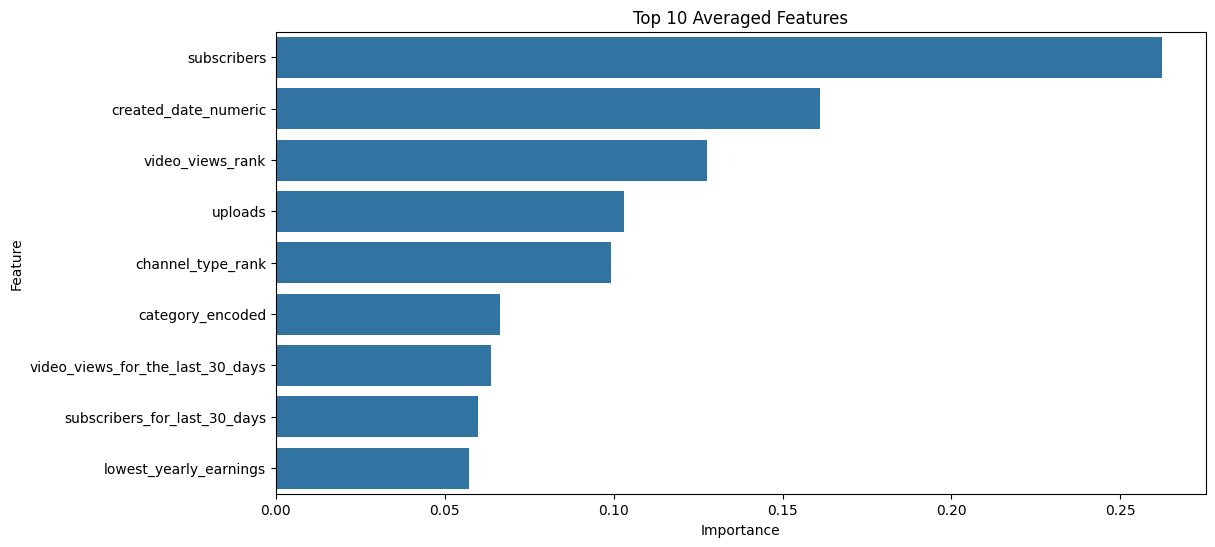

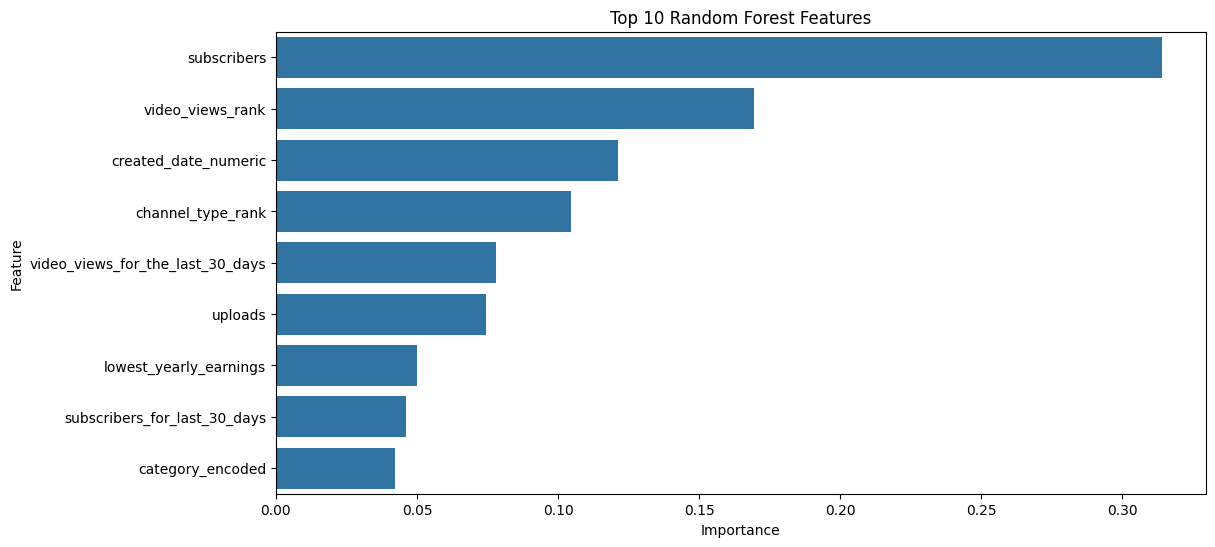

In [12]:
# --- 6.1 Final Model Training (Best Tuned Individual Models) ---
print("\n6.1 Final Model Training (Best Tuned Individual Models)...")

# Get the best individual models from tuning
final_xgb_model = grid_search_xgb.best_estimator_
final_rf_model = random_search_rf.best_estimator_

# We don't need to re-fit them here as they were already fitted during GridSearchCV/RandomizedSearchCV
# on the full dataset X, y (due to grid_search_xgb.fit(X, y) and random_search_rf.fit(X, y)).
# If you had a separate train/test split earlier, you would fit on X_train, y_train here.
# For simplicity, since the search was on X, y, we'll proceed directly to prediction.

print(f"Best XGBoost model parameters: {final_xgb_model.get_params()}")
print(f"Best Random Forest model parameters: {final_rf_model.get_params()}")

# --- 6.2 Ensemble Prediction and Evaluation on Original Scale ---
print("\n6.2 Ensemble Prediction and Evaluation on Original Scale...")

# For demonstration, let's use a fresh train-test split for final evaluation.
# This ensures we evaluate on data truly unseen by this specific combination.
X_train_final, X_test_final, y_train_log, y_test_log = train_test_split(X, y, test_size=0.2, random_state=42)

# Make predictions from each model on the log-transformed test set
y_pred_xgb_log = final_xgb_model.predict(X_test_final)
y_pred_rf_log = final_rf_model.predict(X_test_final)

# Average the predictions (still on the log-scale)
y_pred_ensemble_log = (y_pred_xgb_log + y_pred_rf_log) / 2

# Get the corresponding original y_test values for evaluation
df_original_y = pd.read_csv('Global-YouTube-Statistics.csv', encoding='latin1')
y_original_scale = df_original_y[target]
y_test_original_for_eval = y_original_scale.loc[y_test_log.index]

# Convert ensemble predictions AND actual values back to original scale for MAE/R2 calculation
y_pred_ensemble_original_scale = np.expm1(y_pred_ensemble_log)
# The y_test_original_for_eval is already untransformed

# Calculate metrics for the ensemble on the original scale
mae_ensemble_original = mean_absolute_error(y_test_original_for_eval, y_pred_ensemble_original_scale)
r2_ensemble_original = r2_score(y_test_original_for_eval, y_pred_ensemble_original_scale)

print(f"  Ensemble Model (XGBoost + Random Forest) - MAE (Original Scale): {mae_ensemble_original:.2f}")
print(f"  Ensemble Model (XGBoost + Random Forest) - R-squared (Original Scale): {r2_ensemble_original:.4f}")

# You might also want to compare with individual tuned models on original scale
y_pred_xgb_original_scale = np.expm1(y_pred_xgb_log)
mae_xgb_original = mean_absolute_error(y_test_original_for_eval, y_pred_xgb_original_scale)
r2_xgb_original = r2_score(y_test_original_for_eval, y_pred_xgb_original_scale)
print(f"\n  Tuned XGBoost Model - MAE (Original Scale): {mae_xgb_original:.2f}")
print(f"  Tuned XGBoost Model - R-squared (Original Scale): {r2_xgb_original:.4f}")

y_pred_rf_original_scale = np.expm1(y_pred_rf_log)
mae_rf_original = mean_absolute_error(y_test_original_for_eval, y_pred_rf_original_scale)
r2_rf_original = r2_score(y_test_original_for_eval, y_pred_rf_original_scale)
print(f"\n  Tuned Random Forest Model - MAE (Original Scale): {mae_rf_original:.2f}")
print(f"  Tuned Random Forest Model - R-squared (Original Scale): {r2_rf_original:.4f}")


# --- 6.3 Example: Predicting for a Hypothetical New Channel with Ensemble ---
print("\n6.3 Example: Predicting for a Hypothetical New Channel with Ensemble...")

# For simplicity, let's take the first row of your original (scaled) X as an example,
# and pretend it's a 'new' channel to show the full prediction process.
# In a real scenario, you would have raw data for a new channel, then apply your label_encoders and scaler.
sample_new_channel_features_scaled = X.iloc[[0]] # Get one row from your already processed X
sample_original_views = np.expm1(y.iloc[0]) # Get its original views for comparison

print(f"Hypothetical channel's actual views (from dataset, original scale): {sample_original_views:.0f}")

# Predict on the log scale with each model
predicted_log_views_xgb = final_xgb_model.predict(sample_new_channel_features_scaled)
predicted_log_views_rf = final_rf_model.predict(sample_new_channel_features_scaled)

# Average the log-scale predictions
predicted_log_views_ensemble = (predicted_log_views_xgb + predicted_log_views_rf) / 2

# Convert ensemble prediction back to original scale
predicted_original_views_ensemble = np.expm1(predicted_log_views_ensemble)

print(f"Predicted views for hypothetical channel (ensemble, log-scale): {predicted_log_views_ensemble[0]:.4f}")
print(f"Predicted views for hypothetical channel (ensemble, original scale): {predicted_original_views_ensemble[0]:.0f}")

# --- 6.4 Feature Importance Analysis ---
print("\n6.4 Feature Importance Analysis...")

# Feature importances from the best-tuned XGBoost model
xgb_feature_importances = final_xgb_model.feature_importances_
xgb_features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_feature_importances
}).sort_values(by='Importance', ascending=False)

print("\n--- XGBoost Feature Importances ---")
print(xgb_features_df)

# Feature importances from the best-tuned Random Forest model
rf_feature_importances = final_rf_model.feature_importances_
rf_features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_feature_importances
}).sort_values(by='Importance', ascending=False)

print("\n--- Random Forest Feature Importances ---")
print(rf_features_df)

# Optional: You can also average the importances if you want a combined view
# Ensure features are in the same order
averaged_importances = (xgb_feature_importances + rf_feature_importances) / 2
averaged_features_df = pd.DataFrame({
     'Feature': X.columns,
     'Importance': averaged_importances
 }).sort_values(by='Importance', ascending=False)
print("\n--- Averaged Ensemble Feature Importances ---")
print(averaged_features_df)

# Optional: Visualization of Feature Importances
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_features_df.head(9))
plt.title('Top 10 XGBoost Features')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=averaged_features_df.head(9))
plt.title('Top 10 Averaged Features')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=rf_features_df.head(9))
plt.title('Top 10 Random Forest Features')
plt.show()


## 7. Conclusion and Next Steps
This notebook now provides a comprehensive machine learning pipeline, including initial baseline evaluation with k-fold cross-validation, hyperparameter tuning for individual models, and the training and evaluation of an averaging ensemble model combining XGBoost and Random Forest. Crucially, it includes evaluation and prediction examples on the original scale of video views using `np.expm1()`, which provides more directly interpretable results for your target audience.

To finalize your research project and discussion:

1. Re-run the Notebook from Top to Bottom: This is essential to apply all changes, including the `np.log1p()` transformation, the expanded hyperparameter search ranges, and to train and evaluate the new ensemble model.

2. Analyze Ensemble Performance: Compare the MAE and R-squared values of the ensemble model on the original scale against the individual tuned models. See if the ensemble provides a notable improvement.

3. Feature Importance Analysis: You can still extract feature importances from your individual `final_xgb_model` and `final_rf_model` to understand their individual contributions. For an ensemble, it's harder to get a single, combined feature importance directly, but you can discuss the importances from each component.

4. Deeper Error Analysis: Compare `y_pred_ensemble_original_scale` with `y_test_original_for_eval`. Look at channels where your ensemble model made the largest errors. Are they very large channels? Channels from specific countries or categories? This can lead to valuable insights for your discussion.

5. Refine Feature Engineering: Based on error analysis or feature importance, you might get ideas for creating even more powerful features (e.g., ratios, interactions, custom aggregations). This is often the biggest driver of R-squared improvement when models are already well-tuned.

6. Report Writing: Structure your research paper discussing your methodology, the challenges of skewed data and how you addressed it (log transformation), the results from baseline CV, the tuning process, the ensemble approach and its performance, and insights from feature importance and error analysis.

This should give you a very strong and impressive foundation for your university research project!